In [ ]:
from __future__ import absolute_import
import warnings

from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import RNN

def _generate_dropout_mask(ones, rate, training=None, count=1):
    def dropped_inputs():
        return K.dropout(ones, rate)
    if count > 1:
        return [K.in_train_phase(
            dropped_inputs,
            ones,
            training=training) for _ in range(count)]
    return K.in_train_phase(
        dropped_inputs,
        ones,
        training=training)

class IndRNNCell(Layer):
    """Independently Recurrent Neural Networks Cell class.
    Derived from the paper [Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN](https://arxiv.org/abs/1803.04831)
    Ref: [Tensorflow implementation](https://github.com/batzner/indrnn)
    # Arguments
        units: Positive integer, dimensionality of the output space.
        recurrent_clip_min: Can be one of None, -1 or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, will calculate the clip value for `relu` activation
        recurrent_clip_max: Can be one of None or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, will calculate the clip value for `relu` activation
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you pass None, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix, used for the linear transformation of the
            recurrent state.
            Can be `None` or an available initializer. Defaults to `None`.
            If None, defaults to uniform initialization.
            If None, and recurrent_clip_min/max is not None, then
            it uses those clip values as for uniform initialization.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, must be 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
    """

    def __init__(self, units,
                 recurrent_clip_min=-2,
                 recurrent_clip_max=2,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer=None,
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 **kwargs):
        super(IndRNNCell, self).__init__(**kwargs)

        if implementation != 2:
            warnings.warn(
                "IndRNN only supports implementation 2 for the moment. Defaulting to implementation = 2")
            implementation = 2

        if recurrent_clip_min is None or recurrent_clip_max is None:
            recurrent_clip_min = None
            recurrent_clip_max = None

        self.units = units
        self.recurrent_clip_min = recurrent_clip_min
        self.recurrent_clip_max = recurrent_clip_max
        self.activation = activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer) \
                                     if recurrent_initializer is not None else None
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = (self.units,)
        self._dropout_mask = None
        self._recurrent_masks = None

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if self.recurrent_clip_min == -1 or self.recurrent_clip_max == -1:
            self.recurrent_clip_min = 0.0

            if hasattr(self, 'timesteps') and self.timesteps is not None:
                self.recurrent_clip_max = pow(2.0, 1. / int(self.timesteps))
            else:
                warnings.warn("IndRNNCell: Number of timesteps could not be determined. \n"
                              "Defaulting to max clipping range of 1.0. \n"
                              "If this model was trained using a specific timestep during training, "
                              "inference may be wrong due to this default setting.\n"
                              "Please ensure that you use the same number of timesteps during training "
                              "and evaluation")
                self.recurrent_clip_max = 1.0

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      name='input_kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.recurrent_initializer is None:
            if self.recurrent_clip_min is not None and self.recurrent_clip_max is not None:
                initialization_value = min(self.recurrent_clip_max, 1.0)
                self.recurrent_initializer = initializers.RandomUniform(-initialization_value,
                                                                  initialization_value)
            else:
                self.recurrent_initializer = initializers.RandomUniform(-1.0, 1.0)

        self.recurrent_kernel = self.add_weight(shape=(self.units,),
                                                name='recurrent_kernel',
                                                initializer=self.recurrent_initializer,
                                                regularizer=self.recurrent_regularizer,
                                                constraint=self.recurrent_constraint)

        if self.recurrent_clip_min is not None and self.recurrent_clip_max is not None:
            if abs(self.recurrent_clip_min):
                abs_recurrent_kernel = K.abs(self.recurrent_kernel)
                min_recurrent_kernel = K.maximum(abs_recurrent_kernel, abs(self.recurrent_clip_min))
                self.recurrent_kernel = K.sign(self.recurrent_kernel) * min_recurrent_kernel

            self.recurrent_kernel = K.clip(self.recurrent_kernel,
                                           self.recurrent_clip_min,
                                           self.recurrent_clip_max)

        if self.use_bias:
            bias_initializer = self.bias_initializer

            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.built = True

    def call(self, inputs, states, training=None):
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=1)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_masks is None):
            _recurrent_mask = _generate_dropout_mask(
                K.ones_like(states[0]),
                self.recurrent_dropout,
                training=training,
                count=1)
            self._recurrent_masks = _recurrent_mask

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_masks = self._recurrent_masks

        h_tm1 = states[0]  # previous state

        if 0. < self.dropout < 1.:
            inputs *= dp_mask[0]

        if 0. < self.recurrent_dropout < 1.:
            h_tm1 *= rec_dp_masks[0]

        h = K.dot(inputs, self.kernel)
        h = h + (h_tm1 * self.recurrent_kernel)

        if self.use_bias:
            h = K.bias_add(h, self.bias)

        h = self.activation(h)

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True
        return h, [h]

    def get_config(self):
        config = {'units': self.units,
                  'recurrent_clip_min': self.recurrent_clip_min,
                  'recurrent_clip_max': self.recurrent_clip_max,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(IndRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class IndRNN(RNN):
    """Independently Recurrent Neural Networks Cell class.
    Derived from the paper [Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN](https://arxiv.org/abs/1803.04831)
    Ref: [Tensorflow implementation](https://github.com/batzner/indrnn)
    # Arguments
        units: Positive integer, dimensionality of the output space.
        recurrent_clip_min: Can be one of None, -1 or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, computes the default clipping range for Relu activations
        recurrent_clip_max: Can be one of None, -1 or float.
            If None, clipping of weights will not take place.
            If float, exact value will be used as clipping range
            If -1, computes the default clipping range for Relu activations
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you pass None, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs.
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        unit_forget_bias: Boolean.
            If True, add 1 to the bias of the forget gate at initialization.
            Setting it to true will also force `bias_initializer="zeros"`.
            This is recommended in [Jozefowicz et al.](http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf)
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output.
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
    # References
        - [Learning to forget: Continual prediction with NestedLSTM](http://www.mitpressjournals.org/doi/pdf/10.1162/089976600300015015)
        - [Supervised sequence labeling with recurrent neural networks](http://www.cs.toronto.edu/~graves/preprint.pdf)
        - [A Theoretically Grounded Application of Dropout in Recurrent Neural Networks](http://arxiv.org/abs/1512.05287)
        - [Independently Recurrent Neural Network (IndRNN): Building A Longer and Deeper RNN](https://arxiv.org/abs/1803.04831)
    """

    def __init__(self, units,
                 recurrent_clip_min=-1,
                 recurrent_clip_max=-1,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer=None,
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=2`.'
                          'Please update your layer call.')
        if K.backend() == 'theano':
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = IndRNNCell(units,
                          recurrent_clip_min=recurrent_clip_min,
                          recurrent_clip_max=recurrent_clip_max,
                          activation=activation,
                          use_bias=use_bias,
                          kernel_initializer=kernel_initializer,
                          recurrent_initializer=recurrent_initializer,
                          bias_initializer=bias_initializer,
                          kernel_regularizer=kernel_regularizer,
                          recurrent_regularizer=recurrent_regularizer,
                          bias_regularizer=bias_regularizer,
                          kernel_constraint=kernel_constraint,
                          recurrent_constraint=recurrent_constraint,
                          bias_constraint=bias_constraint,
                          dropout=dropout,
                          recurrent_dropout=recurrent_dropout,
                          implementation=implementation)
        super(IndRNN, self).__init__(cell,
                                     return_sequences=return_sequences,
                                     return_state=return_state,
                                     go_backwards=go_backwards,
                                     stateful=stateful,
                                     unroll=unroll,
                                     **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def build(self, input_shape):
        timesteps = input_shape[1]

        if timesteps is None:
            warnings.warn("Number of timesteps was not provided. If this model is being used for training purposes, \n"
                          "it is recommended to provide a finite number of timesteps when defining the input shape, \n"
                          "so as to initialize the weights of the recurrent kernel properly and avoid exploding gradients.")

        self.cell.timesteps = timesteps

        super(IndRNN, self).build(input_shape)

    def call(self, inputs, mask=None, training=None, initial_state=None, constants=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_masks = None
        return super(IndRNN, self).call(inputs,
                                        mask=mask,
                                        training=training,
                                        initial_state=initial_state,
                                        constants=constants)

    @property
    def units(self):
        return self.cell.units

    @property
    def recurrent_clip_min(self):
        return self.cell.recurrent_clip_min

    @property
    def recurrent_clip_max(self):
        return self.cell.recurrent_clip_max

    @property
    def activation(self):
        return self.cell.activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'recurrent_clip_min': self.recurrent_clip_min,
                  'recurrent_clip_max': self.recurrent_clip_max,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(IndRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 2
        return cls(**config)

In [ ]:
# First we will import the necessary Library 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
!pip install yfinance
!pip install plotly

     |████████████████████████████████| 6.4 MB 7.4 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf

data = yf.download('BTC-USD')

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.reset_index(level=0, inplace=True)

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
2790,2022-05-08,35502.941406,35502.941406,33878.964844,34059.265625,34059.265625,36763041910
2791,2022-05-09,34060.015625,34222.074219,30296.953125,30296.953125,30296.953125,63355494961
2792,2022-05-10,30273.654297,32596.308594,29944.802734,31022.906250,31022.906250,59811038817
2793,2022-05-11,31016.183594,32013.402344,28170.414062,28936.355469,28936.355469,70388855818


In [ ]:
closedf = data[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)


closedf = closedf[closedf['Date'] > '2017-01-01']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Shape of close dataframe: (2795, 2)
Total data for prediction:  1957


In [ ]:
del closedf['Date']

scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1957, 1)


In [ ]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1174, 1)
test_data:  (783, 1)


In [ ]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1158, 15)
y_train:  (1158,)
X_test:  (767, 15)
y_test (767,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1158, 15, 1)
X_test:  (767, 15, 1)


In [ ]:
RECURRENT_MAX = pow(2, 1 / time_step)
model = tf.keras.models.Sequential()
model.add(IndRNN(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(IndRNN(512,return_sequences=False))

model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ind_rnn (IndRNN)            (None, 15, 512)           1024      
                                                                 
 ind_rnn_1 (IndRNN)          (None, 512)               262656    
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 264,193
Trainable params: 264,193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.0000001,)
callbacks = [es , lr_red]
#adamOpt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    validation_split=0.25, 
                    batch_size=512, 
                    verbose=1, 
                    shuffle=False, 
                    callbacks = callbacks)

Epoch 1/10
2/2 [==============================] - 3s 813ms/step - loss: 0.0733 - val_loss: 0.0933 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 1s 350ms/step - loss: 0.0507 - val_loss: 0.0829 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 1s 345ms/step - loss: 0.0632 - val_loss: 0.1027 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 1s 345ms/step - loss: 0.0555 - val_loss: 0.0209 - lr: 0.0010
Epoch 5/10
2/2 [==============================] - 1s 351ms/step - loss: 0.0223 - val_loss: 0.0593 - lr: 0.0010
Epoch 6/10
2/2 [==============================] - 1s 529ms/step - loss: 0.0421 - val_loss: 0.0400 - lr: 0.0010
Epoch 7/10
2/2 [==============================] - 1s 536ms/step - loss: 0.0174 - val_loss: 0.0177 - lr: 0.0010
Epoch 8/10
2/2 [==============================] - 1s 585ms/step - loss: 0.0222 - val_loss: 0.0335 - lr: 0.0010
Epoch 9/10
2/2 [==============================] - 1s 536ms/step - loss: 0.0252 - val_loss: 0.0104 - lr: 0.0010
E

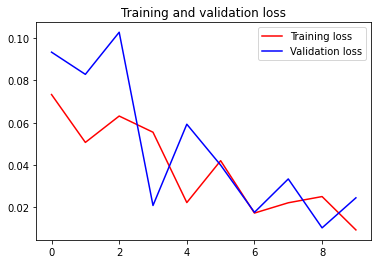

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((1158, 1), (767, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1481.346277960811
Train data MSE:  2194386.7952283486
Train data MAE:  1150.1341788336404
-------------------------------------------------------------------------------------
Test data RMSE:  8967.644511845212
Test data MSE:  80418648.09082754
Test data MAE:  7206.651652389586


In [ ]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9171764022894969
Test data explained variance regression score: 0.9092176158243064


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.8140205553729272
Test data R2 score: 0.746554074696608


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1957, 1)
Test predicted data:  (1957, 1)


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({'last_original_days_value':last_original_days_value, 'next_predicted_days_value':next_predicted_days_value})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'], new_pred_plot['next_predicted_days_value']], labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',plot_bgcolor='black', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



In [ ]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
if(original_ytest.all()< test_predict.all()):
  print('buy')
else:
  print('sell')

sell
